# Prediction based on Sigmoid based model

In [5]:
import pickle
import numpy as np
import pandas as pd
import sklearn.model_selection as sks
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
import seaborn as sns
import random
import keras
import tensorflow as tf
import collections


In [6]:
# fix random seed for reproducibility
np.random.seed(2)
tf.random.set_seed(10)
random.seed(0)

# Load data

In [7]:

def get_data(Xtrain,Xtest,set_clusters,n,adata_c,adata1_c,markers):
            df = markers.loc[markers["cluster"].isin(set_clusters),:]
            feat_tab = df.groupby('cluster')
            df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
            feat=df2.groupby('cluster').head(n)
            
            idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
            idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

            Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
            Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
            Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
            Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))    
            return Xtrain,Xtest


In [8]:
data = collections.defaultdict(list)
path= "../../chr2chr1/"
files= ['Xtest','Xall','Ctest','Call','state']
ext= ['','_mono','_mono_neu','_neu']
for fl in files:
    for ex in ext:
        car= fl+ex
        with open(path+fl+ex+".pkl", "rb") as f:
            buf = pickle.load(f)
        if fl ==  'Xall':
            buf=np.concatenate([buf[0],buf[1]])
        data[car]=buf
        
markers= pd.read_csv('../scripts/marker_cohort2')
markers["avg_log2FC"] = np.abs(markers["avg_log2FC"])

In [9]:
label='all'
Xtrain = data['Xall']
Xtest = data['Xtest']
set_clusters=np.unique(markers["cluster"])
n = 5
adata_c = data['Call']
adata1_c = data['Ctest']
Xtrain,Xtest = get_data(Xtrain,Xtest,set_clusters,n,adata_c,adata1_c,markers)
state = data['state']


In [10]:
random.shuffle(Xtrain)

## Format data as matrices of data and arrays of labels

In [11]:
xtr = np.array([list(np.array(np.mean(x, axis=0))[0] )for (x,y, *_) in Xtrain])
ytr = [y for (x,y, *_) in Xtrain]   
xtr_test = np.array([list(np.array(np.mean(x, axis=0))[0] )for (x,y, *_) in Xtest])
ytr_test = [y for (x,y, *_) in Xtest]


# Learning model_ NN with sigmoid function and 2 nodes

In [12]:
def train(model, trainDataOne,y):
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam')
  
    # Model compiling settings
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

    # A mechanism that stops training if the validation loss is not improving for more than n_idle_epochs.
    n_idle_epochs = 100
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.001)
    # Creating a custom callback to print the log after a certain number of epochs
    class NEPOCHLogger(tf.keras.callbacks.Callback):
        def __init__(self,per_epoch=100):
            '''
            display: Number of batches to wait before outputting loss
            '''
            self.seen = 0
            self.per_epoch = per_epoch

        def on_epoch_end(self, epoch, logs=None):
          if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.2f}, val_loss {:.2f}, mae {:.2f}, val_mae {:.2f}'\
                  .format(epoch, logs['loss'], logs['val_loss'],logs['accuracy'], logs['val_accuracy']))

    # Call the object
    log_display = NEPOCHLogger(per_epoch=100)
    # Training loop
    n_epochs = 2000
    history = model.fit(
      trainDataOne, y, batch_size=1,
      epochs=n_epochs, validation_split = 0.2, verbose=0, callbacks=[log_display,earlyStopping])
    return model, history

In [13]:
def build_classifier():
    model = tf.keras.Sequential([
    keras.layers.Dropout(0.2,input_shape=(Xtrain[0][0].shape[1],)),
    keras.layers.Dense(2, activation='sigmoid'),
    ])
    return model

In [14]:
model = build_classifier()
model, history= train(model, pd.DataFrame(xtr), tf.keras.utils.to_categorical(ytr))
predictions = model.predict(xtr_test)#.flatten()
predictions = predictions[:,1]-predictions[:,0]
yy=np.argmax(model.predict(xtr_test), axis=1)


Epoch 0, loss 0.91, val_loss 0.75, mae 0.47, val_mae 0.60
Epoch 100, loss 0.47, val_loss 0.52, mae 0.75, val_mae 0.80
Epoch 200, loss 0.45, val_loss 0.51, mae 0.77, val_mae 0.70
Epoch 300, loss 0.40, val_loss 0.50, mae 0.77, val_mae 0.70
Epoch 400, loss 0.32, val_loss 0.49, mae 0.82, val_mae 0.70
Epoch 500, loss 0.36, val_loss 0.48, mae 0.80, val_mae 0.70
Epoch 600, loss 0.27, val_loss 0.46, mae 0.85, val_mae 0.80
Epoch 700, loss 0.27, val_loss 0.45, mae 0.90, val_mae 0.70
Epoch 800, loss 0.33, val_loss 0.45, mae 0.85, val_mae 0.80


# Evaluation

<AxesSubplot:>

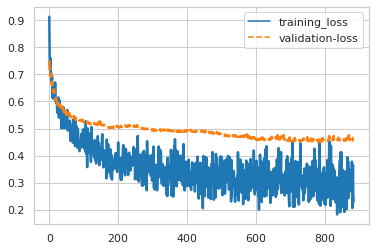

In [15]:
# Returning the desired values for plotting and turn to numpy array
mae = np.asarray(history.history['loss'])
val_mae = np.asarray(history.history['val_loss'])
# Creating the data frame
num_values = (len(mae))
values = np.zeros((num_values,2), dtype=float)
values[:,0] = mae
values[:,1] = val_mae
# Using pandas to frame the data
steps = pd.RangeIndex(start=0,stop=num_values)
data = pd.DataFrame(values, steps, columns=["training_loss", "validation-loss"])
# Plotting
sns.set(style="whitegrid")
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

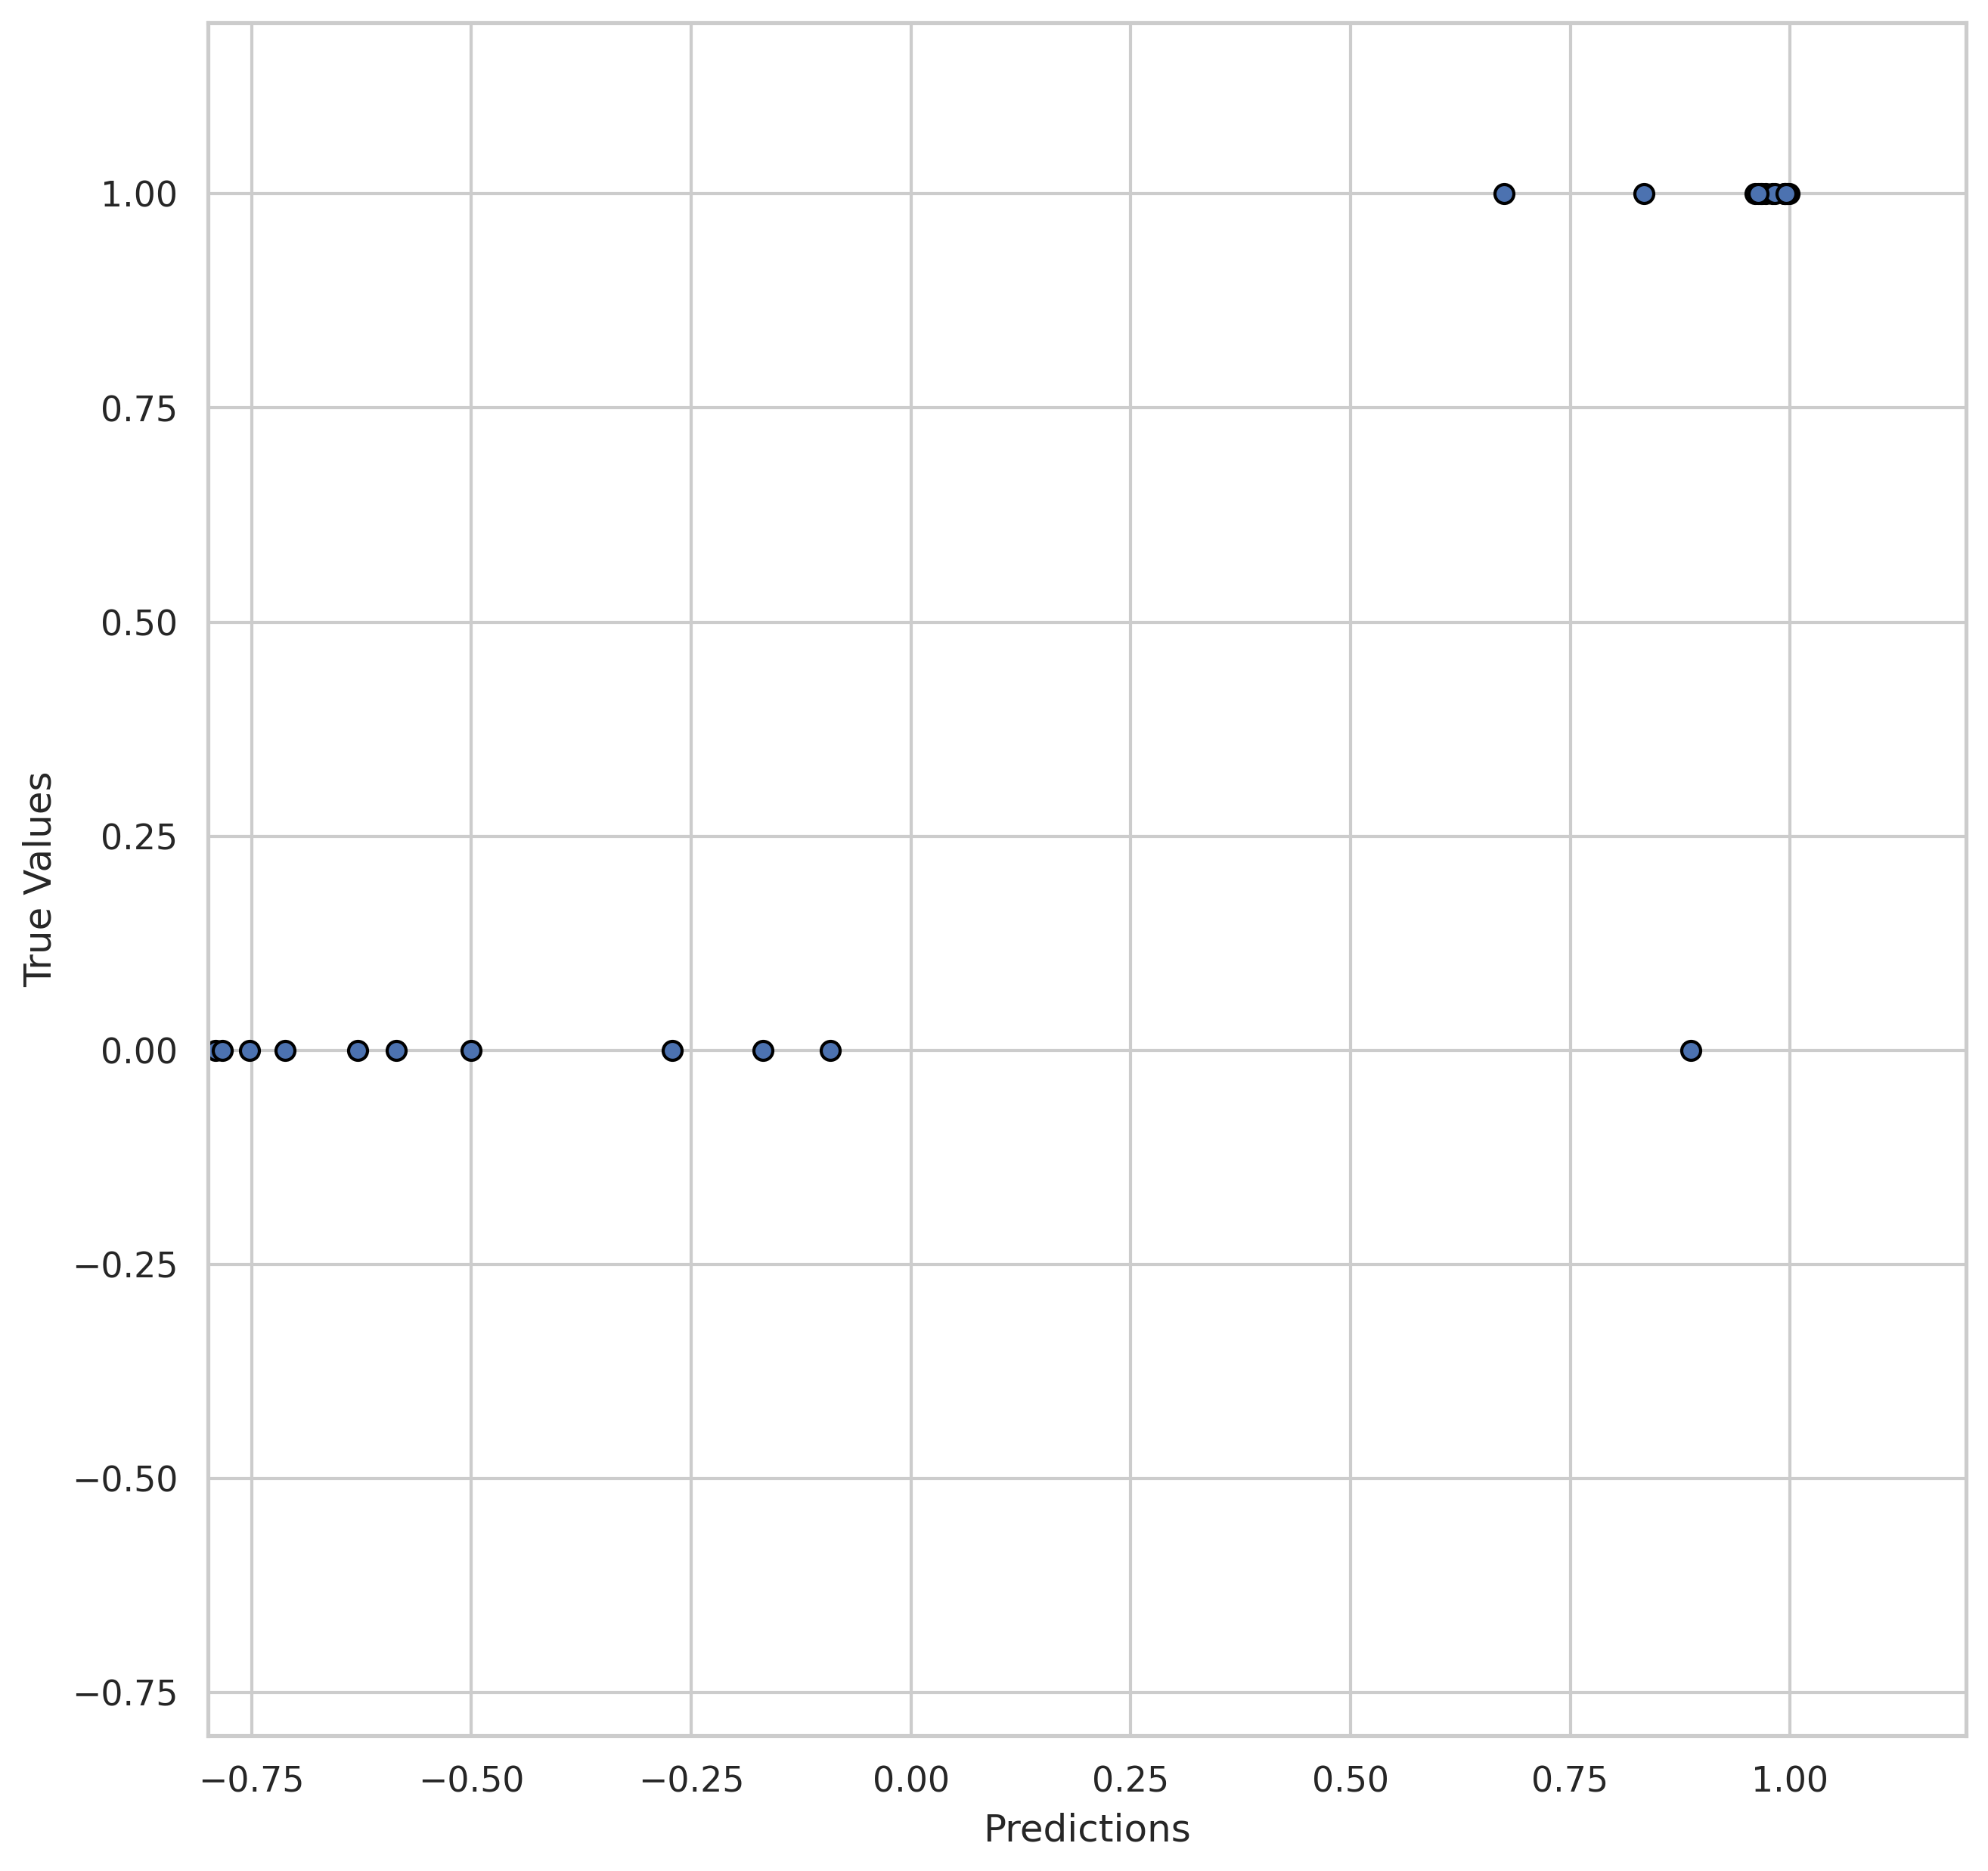

In [16]:
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':300, 'font.size':22}):
    plt.scatter(predictions, ytr_test, edgecolors=(0, 0, 0))
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    lims = [-0.8, 1.2]
    plt.xlim(lims)
    plt.ylim(lims)
#     _ = plt.plot(lims, lims)

In [17]:
skm.accuracy_score(ytr_test, yy)

0.9629629629629629

In [18]:
print(skm.classification_report(ytr_test, yy))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.93      1.00      0.97        14

    accuracy                           0.96        27
   macro avg       0.97      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



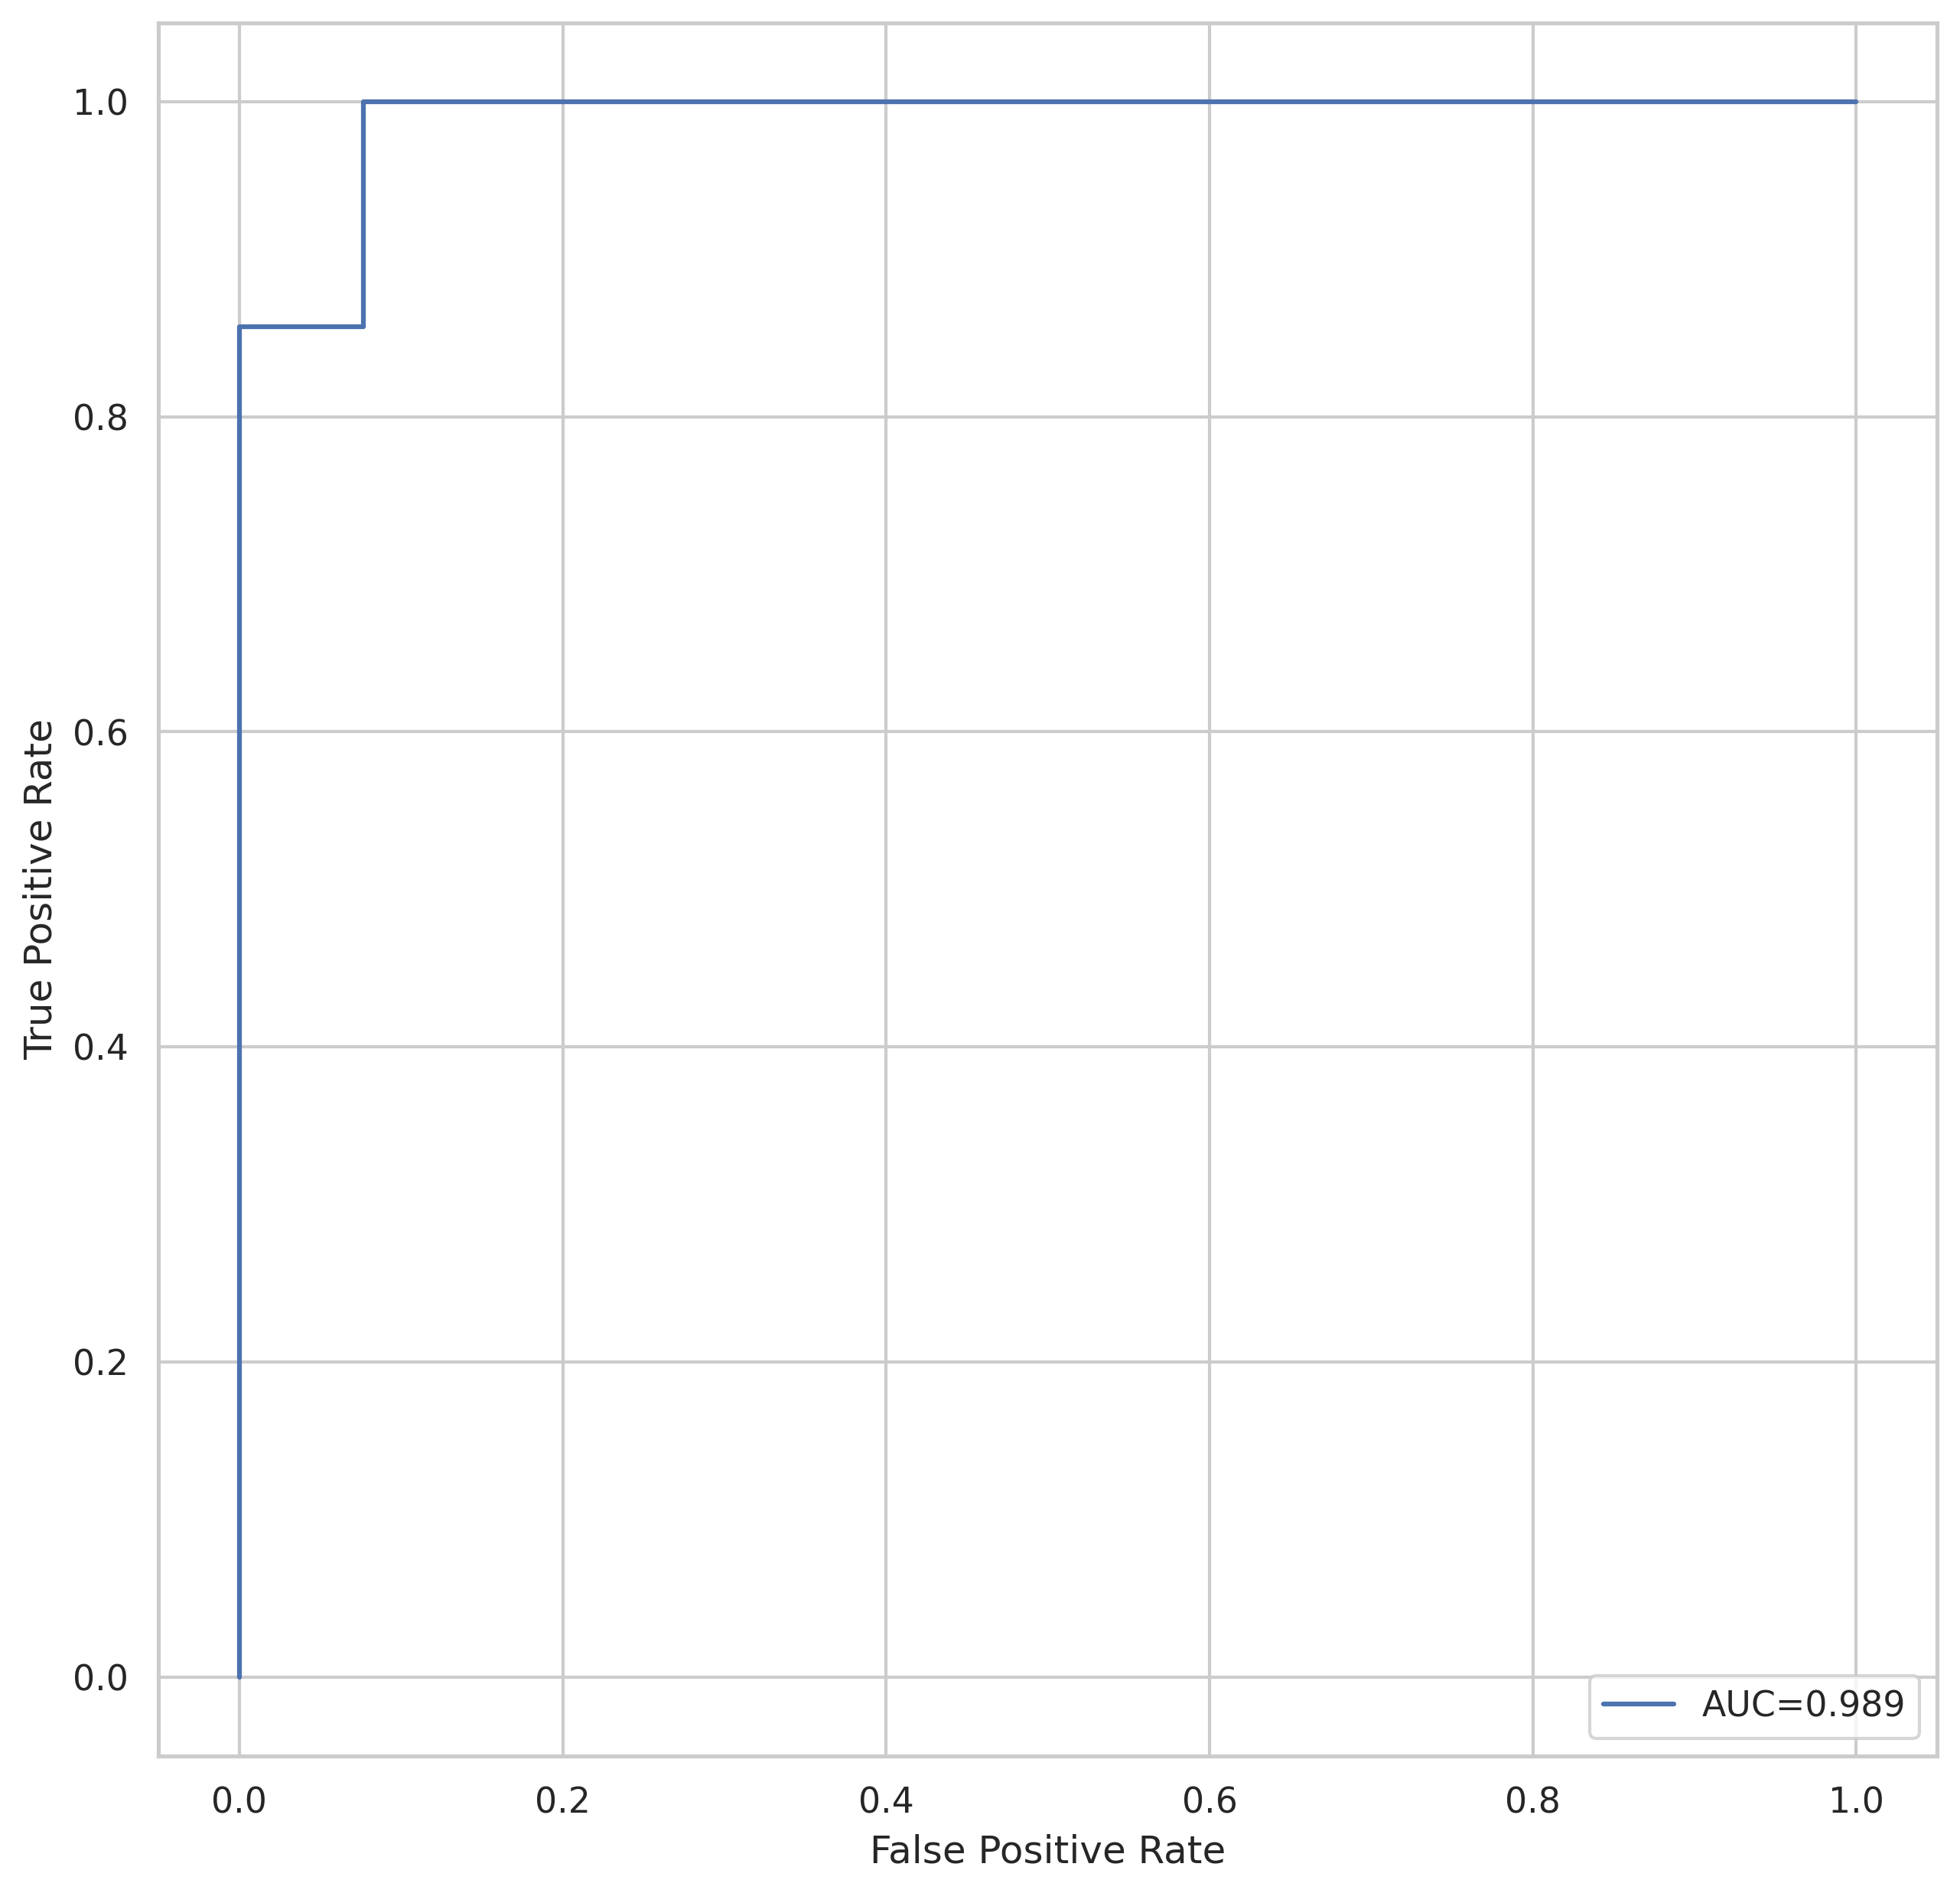

In [19]:
    classes_=[0,1]   
    fpr, tpr, _ = skm.roc_curve(ytr_test,  predictions)
    auc = round(skm.roc_auc_score(ytr_test,  predictions),3)

    #create ROC curve
    with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':300, 'font.size':22}):

        plt.plot(fpr,tpr,label="AUC="+str(auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
#         plt.title("Linear model_20 marker genes")
        plt.show()



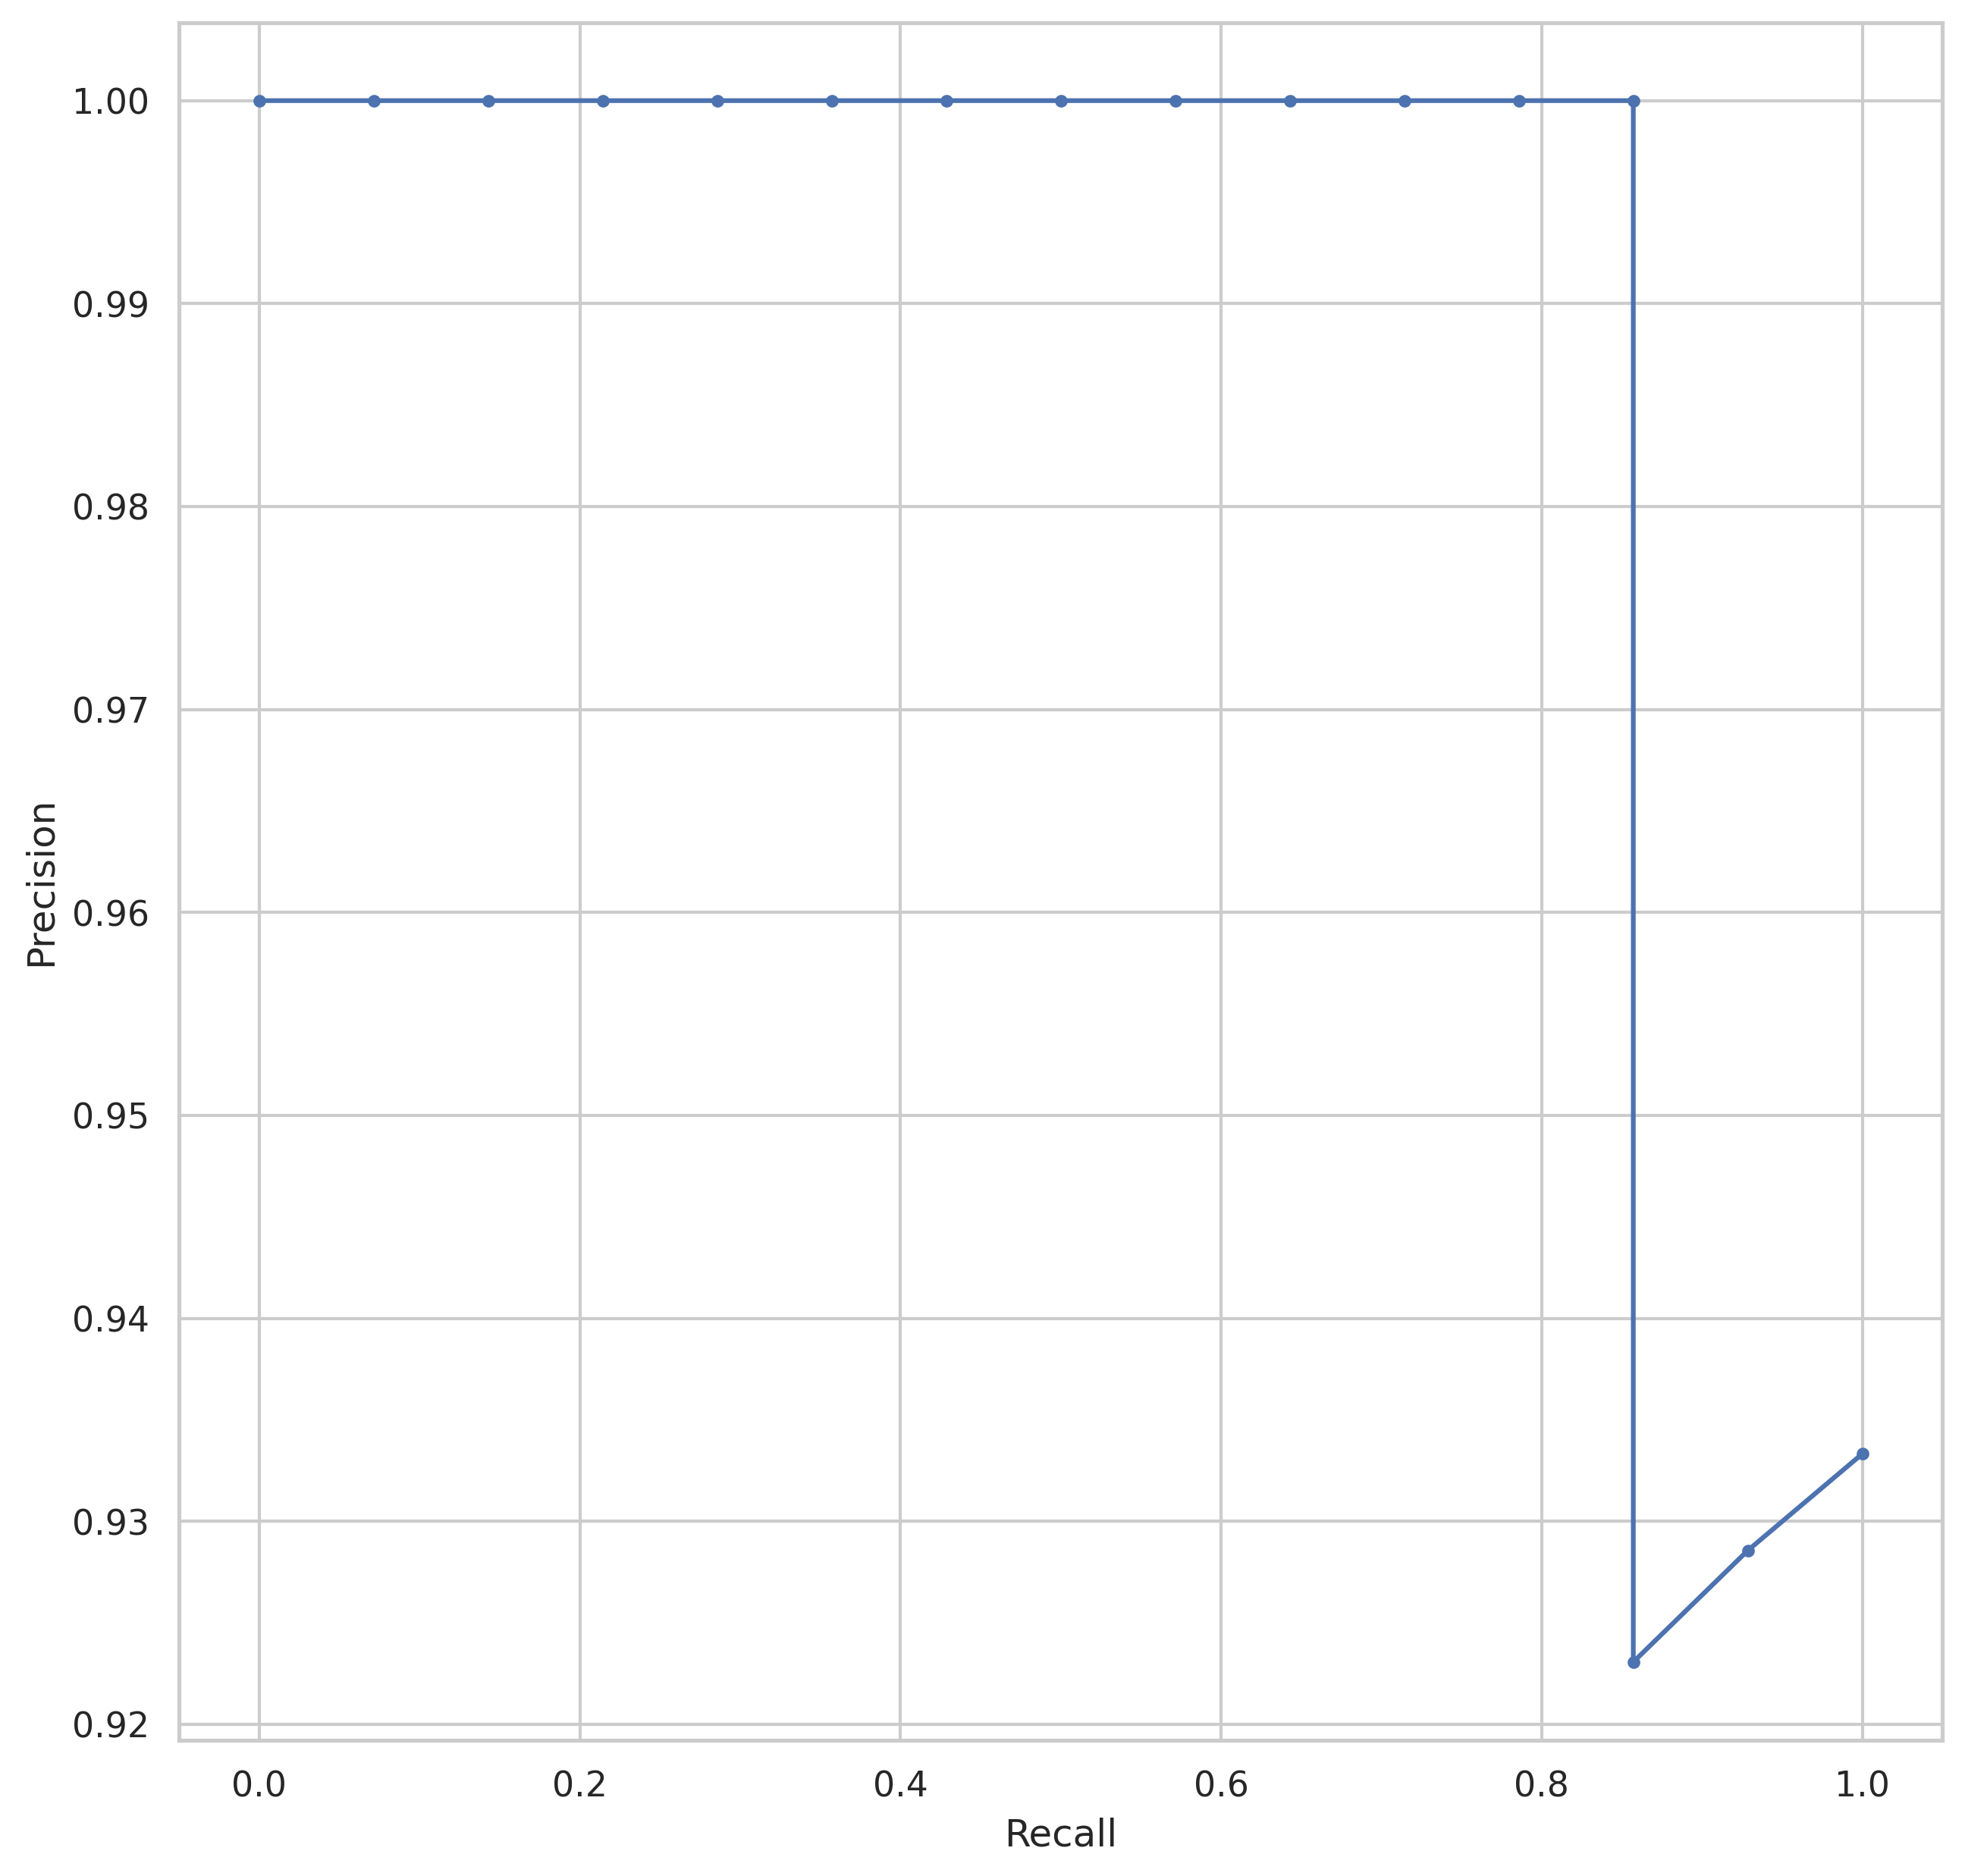

In [20]:
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':300, 'font.size':14}):

    lr_precision, lr_recall, _ = skm.precision_recall_curve(ytr_test,  predictions)
    # lr_f1, lr_auc = skm.f1_score(ytr_test,  y_true), skm.auc(lr_recall, lr_precision)
    # summarize scores
    # print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    y_test = np.array(ytr_test)
    # no_skill = len(ytr_test[ytr_test==1]) / len(ytr_test)
    # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    # show the plot
    plt.show()

# SVM model

In [27]:
from sklearn import svm

In [52]:
c_values = [1.0, 0.1,1.5, 2.0]
kernel_values = [ 'linear', 'poly', 'rbf', 'sigmoid' ]
class_weight = ['balanaced', None]
hyperparam_grid = dict(C=c_values, kernel=kernel_values, class_weight= class_weight)
s = svm.SVC(random_state=42,  probability=True)
clf = sks.GridSearchCV(s,hyperparam_grid,scoring='f1',cv=5, refit=True)
grid_result = clf.fit(xtr, ytr)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.810606 using {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}


In [61]:
pred2=clf.predict_proba(xtr_test)[:,1]
pred=clf.predict(xtr_test)

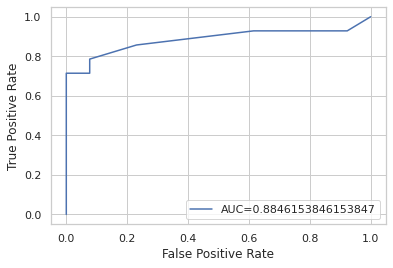

0.8846153846153847


In [62]:
    classes_=[0,1]
    fpr, tpr, _ = skm.roc_curve(ytr_test,  pred2)
    auc = skm.roc_auc_score(ytr_test,  pred2)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print(auc)

In [63]:
print(skm.classification_report(ytr_test, pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.71      0.83        14

    accuracy                           0.85        27
   macro avg       0.88      0.86      0.85        27
weighted avg       0.89      0.85      0.85        27

